In [1]:
using Interact
using GeometryTypes
using FixedSizeArrays
using LCMGL
using AffineTransforms
using SpatialFields
using ForwardDiff
using Gadfly
using DataFrames, DataArrays

    *(#T<:Any, Type{Measures.Length{:cx, T<:Any}}) at /Users/rdeits/locomotion/explorations/point-cloud-signed-distance/packages/v0.4/Compose/src/measure.jl:13
is ambiguous with: 
    *(MultiPoly.MPoly, Any) at /Users/rdeits/locomotion/explorations/point-cloud-signed-distance/packages/v0.4/MultiPoly/src/mpolyarithmetic.jl:81.
To fix, define 
    *(_<:MultiPoly.MPoly, Type{Measures.Length{:cx, T<:Any}})
before the new definition.
    *(#T<:Any, Type{Measures.Length{:cy, T<:Any}}) at /Users/rdeits/locomotion/explorations/point-cloud-signed-distance/packages/v0.4/Compose/src/measure.jl:14
is ambiguous with: 
    *(MultiPoly.MPoly, Any) at /Users/rdeits/locomotion/explorations/point-cloud-signed-distance/packages/v0.4/MultiPoly/src/mpolyarithmetic.jl:81.
To fix, define 
    *(_<:MultiPoly.MPoly, Type{Measures.Length{:cy, T<:Any}})
before the new definition.
    promote_rule(Type{#T<:Any}, Type{DataArrays.NAtype}) at /Users/rdeits/locomotion/explorations/point-cloud-signed-distance/packages

In [2]:
import DrakeVisualizer: Visualizer, draw

In [3]:
include("arms.jl")

Arms

In [4]:
include("depth_sensors.jl")

DepthSensors

In [5]:
# Construct the manipulator and visualizer
arm = Arms.two_link_arm();
vis = Visualizer(arm);

In [6]:
# Construct the sensor and draw its view rays for debugging
sensor = DepthSensors.Kinect(80,80);
camera_origin = tformtranslate([0;0;4]) * tformrotate([pi;0;0])
LCMGLClient("sensor_rays") do lcmgl
    LCMGL.color(lcmgl, 0, 1, 0)
    begin_mode(lcmgl, LCMGL.LINES)
    for ray in sensor.rays
        vertex(lcmgl, camera_origin.offset...)
        vertex(lcmgl, (camera_origin.offset + camera_origin.scalefwd * convert(Vector, ray))...)
    end
    end_mode(lcmgl)
    switch_buffer(lcmgl)
end

In [7]:
# A helper function that takes the two arm angles, computes the implicit 
# surface, performs a raycast, and draws the result. 
function raycast_arm(x1, x2)
    origins = Arms.link_origins(arm, [x1; x2])
    draw(vis, origins)
    skin = Arms.skin(arm, [x1; x2])
    Visualizer(DrakeVisualizer.GeometryData(convert(GeometryTypes.HomogenousMesh, skin)), 2)
    
    points = DepthSensors.raycast_points(skin, sensor, camera_origin)
    LCMGLClient("raycast") do lcmgl
        LCMGL.color(lcmgl, 0, 1, 0)
        point_size(lcmgl, 5)
        begin_mode(lcmgl, LCMGL.POINTS)
        for point in points
            vertex(lcmgl, convert(Vector, point)...)
        end
        end_mode(lcmgl)
        switch_buffer(lcmgl)
    end
    points
end

raycast_arm (generic function with 1 method)

In [8]:
@manipulate for x1 = linspace(-pi, pi, 101), x2 = linspace(-pi, pi, 101)
    points = raycast_arm(x1, x2)
end;

Interact.Slider{Float64}(Signal{Float64}(0.0, nactions=0),"x1",0.0,linspace(-3.141592653589793,3.141592653589793,101),true)

Interact.Slider{Float64}(Signal{Float64}(0.0, nactions=0),"x2",0.0,linspace(-3.141592653589793,3.141592653589793,101),true)

In [9]:
# Difference between two angles, compensating for wraparound
# (taken from angleDiff.m in Drake)
function angle_diff(phi1, phi2)
    mod(phi2 - phi1 + pi, 2*pi) - pi;
end

angle_diff (generic function with 1 method)

In [10]:
# Now let's try to use the raycast data to recover the joint angles.
# We'll do that by choosing a true (hidden) robot state:
x_true = [-1; 1.3]

# Now we can raycast that true state to get a set of sensed points:
sensed_points = raycast_arm(x_true...)

# Our cost function takes the two joint angles and returns the 
# squared sum of the value of the implicit surface at those sensed
# points. If we've recovered the true joint state, then that sum
# should be nearly zero. 
function cost(x)
    skin = Arms.skin(arm, x)
    return sum(point -> evaluate(skin, point)^2, sensed_points)
end


# Use autodiff to prepare a function that will evaluate the gradient
# of that cost:
g_cost = ForwardDiff.gradient(cost)

trials = []

function test_gradient_descent()
    for i = 1:100
        errors = []
        xs = []

        # We'll initialize our estimate with a uniformly random pair
        # of joint angles
        x_estimated = rand(2) * 2*pi - pi

        # Now we use gradient descent to recover the joint angles
        for i = 1:50
            push!(xs, x_estimated)
            push!(errors, norm(angle_diff(x_estimated, x_true)))

            # Evaluate the gradient of the point values w.r.t. the
            # joint angles:
            gi = g_cost(x_estimated)

            if any(isnan, gi)
                @show x_estimated
                error("NaN in gradient")
            end

            # Descend the gradient
            x_estimated -= 0.0005 * gi
        end
        push!(trials, DataFrame(x=xs, err=errors))
#         push!(trials, (xs, errors))
    end
end

test_gradient_descent (generic function with 1 method)

In [11]:
test_gradient_descent()
# trials = []
# Profile.clear
# @time @profile test_gradient_descent()
# ProfileView.view()

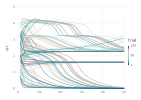

In [12]:
# Now we can plot the progress of each trial

Gadfly.plot([layer(trial, y="err", color=i+zeros(size(trial,1)), Geom.line) for (i, trial) in enumerate(trials)]..., 
    Guide.colorkey("trial"))

In [13]:
vis = Visualizer(arm);
@manipulate for j = 1:length(trials), i = 1:size(trials[1], 1)
    trial = trials[j]
    x1, x2 = trial[:x][i]
    origins = Arms.link_origins(arm, [x1; x2])
    draw(vis, origins)
end

Interact.Slider{Int64}(Signal{Int64}(50, nactions=0),"j",50,1:100,true)

Interact.Slider{Int64}(Signal{Int64}(25, nactions=0),"i",25,1:50,true)

nothing

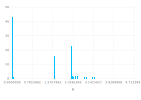

In [14]:
# A histogram of the final cost of each trial shows that most random
# configurations eventually converged to the correct answer (a final
# cost near 0.0), but that some got stuck in local minima

Gadfly.plot(x=[trial[:err][end] for trial in trials], Geom.histogram, Guide.xticks(ticks=collect(0:pi/4:3*pi/2)))

In [15]:
# Now let's repeat the trial, but starting within + or - 0.5 of the true
# joint angles (to simulate running online with a good initial guess).

x_true = [-1; 1.3]

sensed_points = raycast_arm(x_true...)

function cost(x)
    skin = Arms.skin(arm, x)
    return sum(point -> evaluate(skin, point)^2, sensed_points)
end

trials_close = []

for i = 1:100
    errors = []
    xs = []
    
    # Start within +- 0.5 of x_true
    x_estimated = (rand(2) - 0.5) + x_true


    g_cost = ForwardDiff.gradient(cost)
    for i = 1:50
        push!(xs, x_estimated)
        push!(errors, norm(angle_diff(x_estimated, x_true)))
        gi = g_cost(x_estimated)
        x_estimated -= 0.0001 * gi
    end
    push!(trials_close, DataFrame(x=xs, err=errors))
end

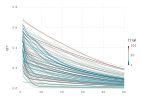

In [16]:
Gadfly.plot([layer(trial, y="err", color=i+zeros(size(trial,1)), Geom.line) for (i, trial) in enumerate(trials_close)]..., 
    Guide.colorkey("trial"))

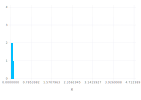

In [17]:
# When starting out reasonably close to the correct configuration, every
# single sample converged to the true joint angles. The histogram confirms:

Gadfly.plot(x=[trial[:err][end] for trial in trials_close], Geom.histogram, Guide.xticks(ticks=collect(0:pi/4:3*pi/2)))

In [18]:
vis = Visualizer(arm);
@manipulate for j = 1:length(trials_close), i = 1:size(trials_close[1], 1)
    trial = trials_close[j]
    x1, x2 = trial[:x][i]
    origins = Arms.link_origins(arm, [x1; x2])
    draw(vis, origins)
end

Interact.Slider{Int64}(Signal{Int64}(50, nactions=0),"j",50,1:100,true)

Interact.Slider{Int64}(Signal{Int64}(25, nactions=0),"i",25,1:50,true)

nothing